#Loading data

In [38]:
%load_ext tensorboard
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import plugins
import tensorflow as tf
import tensorflow.keras as keras
from scipy.spatial import distance

sns.set_style("whitegrid")

# Distribution strategy
device = "gpu"
if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MultiWorkerMirroredStrategy()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


In [39]:
# Downloading data
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
df = pd.read_csv('/content/data.csv')
df.info()

--2021-04-26 01:48:37--  https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1922812 (1.8M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]   1.83M  --.-KB/s    in 0.03s   

2021-04-26 01:48:37 (55.6 MB/s) - ‘data.csv.1’ saved [1922812/1922812]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_community_area   15000 non-null  float64
 1   fare                    15002 non-null  float64
 2   trip_start_month        15002 non-null  int64  
 3 

#Data Preprocessing

In [40]:
df = pd.read_csv('/content/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_community_area   15000 non-null  float64
 1   fare                    15002 non-null  float64
 2   trip_start_month        15002 non-null  int64  
 3   trip_start_hour         15002 non-null  int64  
 4   trip_start_day          15002 non-null  int64  
 5   trip_start_timestamp    15002 non-null  int64  
 6   pickup_latitude         15000 non-null  float64
 7   pickup_longitude        15000 non-null  float64
 8   dropoff_latitude        14519 non-null  float64
 9   dropoff_longitude       14519 non-null  float64
 10  trip_miles              15002 non-null  float64
 11  pickup_census_tract     1 non-null      float64
 12  dropoff_census_tract    10761 non-null  float64
 13  payment_type            15002 non-null  object 
 14  company                 9862 non-null 

In [41]:
df.head(10)

,pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,pickup_census_tract,dropoff_census_tract,payment_type,company,trip_seconds,dropoff_community_area,tips
0,NaN,12.45,5,19,6,1400269500,NaN,NaN,NaN,NaN,0.00,NaN,NaN,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,0.0,NaN,0.0
1,NaN,0.00,3,19,5,1362683700,NaN,NaN,NaN,NaN,0.00,NaN,NaN,Unknown,Chicago Elite Cab Corp.,300.0,NaN,0.0
2,60.0,27.05,10,2,3,1380593700,41.836150,-87.648788,NaN,NaN,12.60,NaN,NaN,Cash,Taxi Affiliation Services,1380.0,NaN,0.0
3,10.0,5.85,10,1,2,1382319000,41.985015,-87.804532,NaN,NaN,0.00,NaN,NaN,Cash,Taxi Affiliation Services,180.0,NaN,0.0
4,14.0,16.65,5,7,5,1369897200,41.968069,-87.721559,NaN,NaN,0.00,NaN,NaN,Cash,Dispatch Taxi Affiliation,1080.0,NaN,0.0
5,13.0,16.45,11,12,3,1446554700,41.983636,-87.723583,NaN,NaN,6.90,NaN,NaN,Cash,NaN,780.0,NaN,0.0
6,16.0,32.05,12,1,1,1417916700,41.953582,-87.723452,NaN,NaN,15.40,NaN,NaN,Cash,NaN,1200.0,NaN,0.0
7,30.0,38.45,10,10,5,1444301100,41.839087,-87.714004,NaN,NaN,14.60,NaN,NaN,Cash,NaN,2580.0,NaN,0.0
8,11.0,14.65,1,1,3,1358213400,41.978830,-87.771167,NaN,NaN,5.81,NaN,NaN,Cash,NaN,1080.0,NaN,0.0
9,33.0,3.25,5,17,1,1368985500,41.849247,-87.624135,NaN,NaN,0.00,NaN,NaN,Cash,Taxi Affiliation Services,0.0,NaN,0.0


In [42]:
df.nunique()

pickup_community_area        62
fare                        423
trip_start_month             12
trip_start_hour              24
trip_start_day                7
trip_start_timestamp      13789
pickup_latitude             236
pickup_longitude            236
dropoff_latitude            291
dropoff_longitude           291
trip_miles                  530
pickup_census_tract           1
dropoff_census_tract        229
payment_type                  7
company                      61
trip_seconds                110
dropoff_community_area       69
tips                        462
dtype: int64

In [43]:
df.describe()

,pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,pickup_census_tract,dropoff_census_tract,trip_seconds,dropoff_community_area,tips
count,15000.000000,15002.000000,15002.000000,15002.000000,15002.000000,1.500200e+04,15000.000000,15000.000000,14519.000000,14519.000000,15002.000000,1.000000e+00,1.076100e+04,14996.000000,14495.000000,15002.000000
mean,22.250267,11.768216,6.585655,13.632316,4.186642,1.408495e+09,41.903046,-87.657551,41.902672,-87.654113,2.872820,1.703108e+10,1.703135e+10,777.627501,20.967782,1.076674
std,19.414828,11.538850,3.390997,6.620927,2.015694,2.916043e+07,0.037751,0.067846,0.038478,0.056616,15.276007,NaN,3.312243e+05,977.538769,17.641056,2.158340
min,1.000000,0.000000,1.000000,0.000000,1.000000,1.357000e+09,41.694879,-87.913625,41.663671,-87.913625,0.000000,1.703108e+10,1.703101e+10,0.000000,1.000000,0.000000
25%,8.000000,5.850000,4.000000,9.000000,2.000000,1.384622e+09,41.880994,-87.655998,41.880994,-87.656804,0.000000,1.703108e+10,1.703108e+10,360.000000,8.000000,0.000000
50%,8.000000,7.850000,7.000000,15.000000,4.000000,1.407260e+09,41.892508,-87.633308,41.893216,-87.634156,1.000000,1.703108e+10,1.703124e+10,540.000000,12.000000,0.000000
75%,32.000000,12.450000,10.000000,19.000000,6.000000,1.431339e+09,41.921877,-87.626211,41.922686,-87.626215,2.500000,1.703108e+10,1.703183e+10,960.000000,32.000000,2.000000
max,77.000000,700.070000,12.000000,23.000000,7.000000,1.483116e+09,42.009623,-87.572782,42.021224,-87.540936,1710.000000,1.703108e+10,1.703198e+10,72120.000000,77.000000,47.000000


In [44]:
#Droping unwanted columns
df = df.drop(['trip_start_timestamp','trip_miles','pickup_census_tract'
             , 'dropoff_census_tract','trip_seconds','payment_type','tips'
             , 'company','dropoff_community_area','pickup_community_area']
             , axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               15002 non-null  float64
 1   trip_start_month   15002 non-null  int64  
 2   trip_start_hour    15002 non-null  int64  
 3   trip_start_day     15002 non-null  int64  
 4   pickup_latitude    15000 non-null  float64
 5   pickup_longitude   15000 non-null  float64
 6   dropoff_latitude   14519 non-null  float64
 7   dropoff_longitude  14519 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 937.8 KB


In [45]:
print(df.nunique())
df.head()

fare                 423
trip_start_month      12
trip_start_hour       24
trip_start_day         7
pickup_latitude      236
pickup_longitude     236
dropoff_latitude     291
dropoff_longitude    291
dtype: int64


,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,12.45,5,19,6,NaN,NaN,NaN,NaN
1,0.00,3,19,5,NaN,NaN,NaN,NaN
2,27.05,10,2,3,41.836150,-87.648788,NaN,NaN
3,5.85,10,1,2,41.985015,-87.804532,NaN,NaN
4,16.65,5,7,5,41.968069,-87.721559,NaN,NaN


In [46]:
#Dropping all null values
df = df.dropna()

#Dropping outlier fare > 200
df = df.drop(df[df['fare'] > 200].index)

df['trip_start_month'] = df['trip_start_month'].astype('str')
df['trip_start_hour'] = df['trip_start_hour'].astype('str')
df['trip_start_day'] = df['trip_start_day'].astype('str')
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14518 entries, 28 to 15000
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               14518 non-null  float64
 1   trip_start_month   14518 non-null  object 
 2   trip_start_hour    14518 non-null  object 
 3   trip_start_day     14518 non-null  object 
 4   pickup_latitude    14518 non-null  float64
 5   pickup_longitude   14518 non-null  float64
 6   dropoff_latitude   14518 non-null  float64
 7   dropoff_longitude  14518 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1020.8+ KB
None


,fare,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,14518.000000,14518.000000,14518.000000,14518.000000,14518.000000
mean,11.274842,41.902400,-87.654567,41.902671,-87.654115
std,9.406693,0.036682,0.062896,0.038479,0.056618
min,0.000000,41.694879,-87.913625,41.663671,-87.913625
25%,5.850000,41.880994,-87.655879,41.880994,-87.656804
50%,7.850000,41.892508,-87.632746,41.893216,-87.634156
75%,12.050000,41.920802,-87.626211,41.922686,-87.626215
max,175.050000,42.009623,-87.572782,42.021224,-87.540936


In [47]:
#Train test split 
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)

12347
2171


In [48]:
traindf

,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
28,12.25,10,1,1,41.952823,-87.653244,41.920452,-87.679955
29,3.85,3,15,6,41.899670,-87.669838,41.920452,-87.679955
30,6.05,8,23,5,41.906026,-87.675312,41.920452,-87.679955
31,7.25,10,21,7,41.906651,-87.665338,41.920452,-87.679955
32,7.85,11,11,2,41.871016,-87.631407,41.849247,-87.624135
...,...,...,...,...,...,...,...,...
14996,3.45,10,20,4,41.904935,-87.649907,41.904935,-87.649907
14997,3.25,5,11,5,41.904935,-87.649907,41.904935,-87.649907
14998,3.25,11,16,4,41.904935,-87.649907,41.904935,-87.649907
14999,4.25,12,13,3,41.904935,-87.649907,41.904935,-87.649907


In [49]:
evaldf

,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
44,5.85,10,0,7,42.001571,-87.695013,42.001571,-87.695013
68,9.05,2,21,2,41.928619,-87.685362,41.957736,-87.683718
70,5.65,1,19,1,41.929047,-87.651311,41.921877,-87.664078
77,9.65,4,1,2,41.906026,-87.675312,41.892042,-87.631864
81,8.45,7,20,7,41.906026,-87.675312,41.892042,-87.631864
...,...,...,...,...,...,...,...,...
14976,7.45,11,13,1,41.904935,-87.649907,41.892073,-87.628874
14977,8.25,3,3,1,41.904935,-87.649907,41.942585,-87.656644
14984,9.85,4,20,4,41.904935,-87.649907,41.863423,-87.653757
14989,6.05,4,1,1,41.904935,-87.649907,41.907492,-87.635760


#Data Exploration

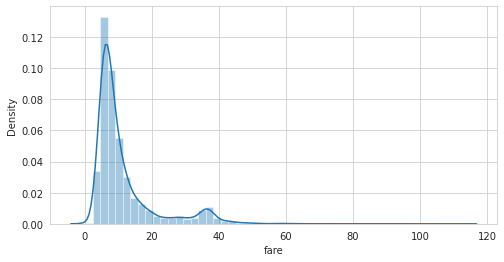

In [50]:
#Plotting Distribution of fare
plt.figure(figsize=(8, 4))
sns.distplot(traindf['fare'])

In [51]:
#Plotting heatmap - intensity as per the fare
m = folium.Map(width=800, height=300)
sw = traindf[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = traindf[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(traindf['pickup_latitude']
                                , traindf['pickup_longitude']
                                , traindf['fare']), radius = 10))
m.fit_bounds([sw, ne])
m

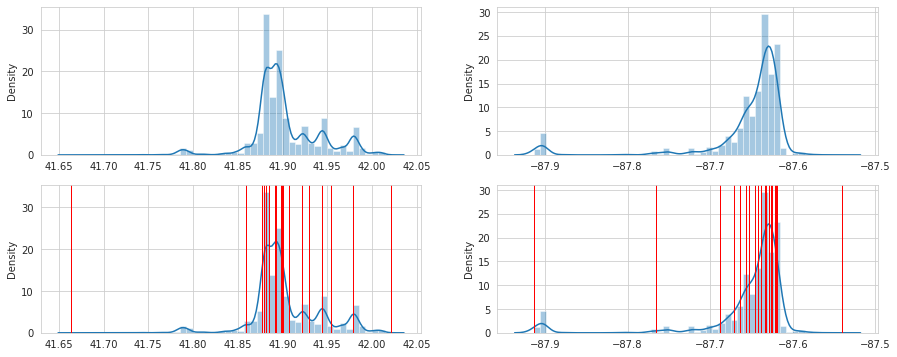

In [52]:
#Quantile Bucketization of latitude and longitude

bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

# Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(15, 6), sharex=False)
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1])

# Plot bins
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

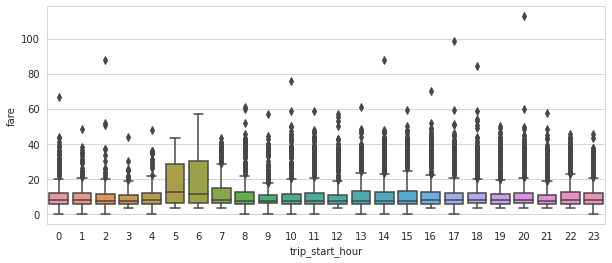

In [53]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare'])

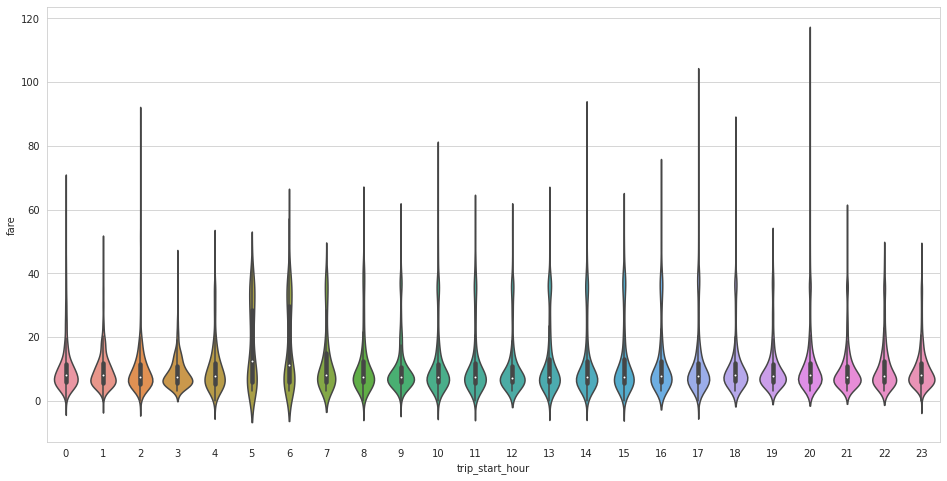

In [54]:
plt.figure(figsize=(16, 8))
sns.violinplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare'])

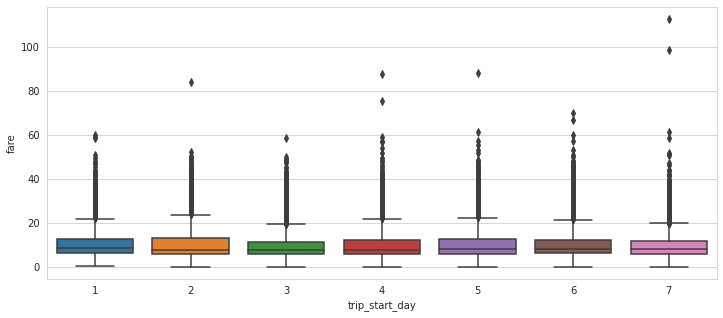

In [55]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=traindf['trip_start_day'].astype(int), y=traindf['fare'])

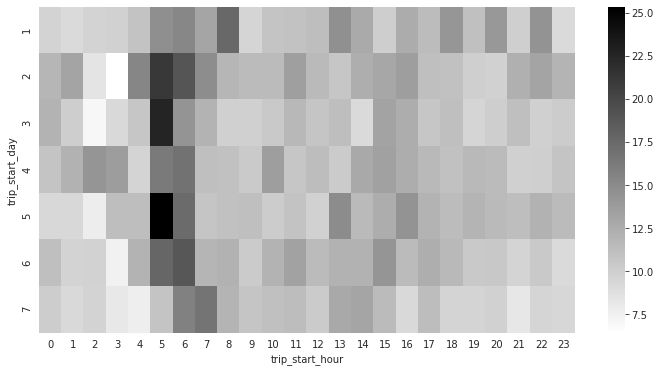

In [56]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(12, 6))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

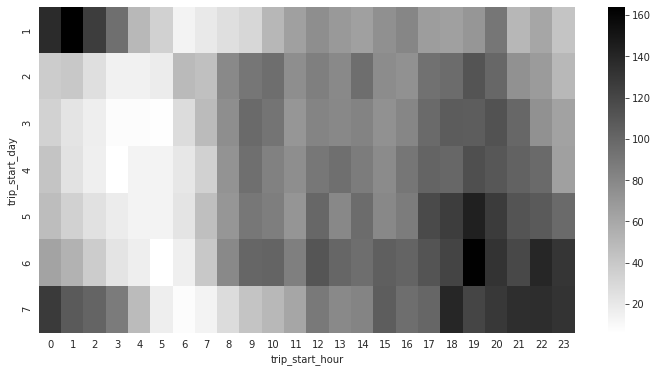

In [57]:
##Number of trips( day-hour wise )
plt.figure(figsize=(12, 6))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

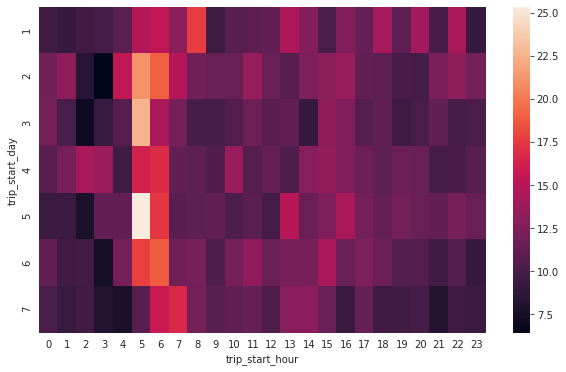

In [58]:
plt.figure(figsize=(10,6))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g')

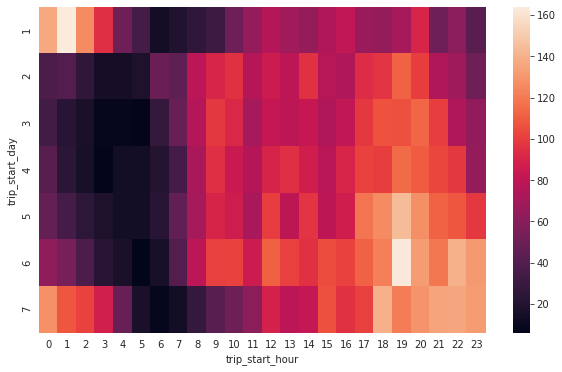

In [59]:
plt.figure(figsize=(10,6))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g')

#Feature Engineering

In [60]:
## Calculate Euclidean distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

traindf = traindf.apply(euclidean, axis=1)
traindf.head() 

,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance
28,12.25,10,1,1,41.952823,-87.653244,41.920452,-87.679955,4.196872
29,3.85,3,15,6,41.899670,-87.669838,41.920452,-87.679955,2.311313
30,6.05,8,23,5,41.906026,-87.675312,41.920452,-87.679955,1.515438
31,7.25,10,21,7,41.906651,-87.665338,41.920452,-87.679955,2.010275
32,7.85,11,11,2,41.871016,-87.631407,41.849247,-87.624135,2.295137


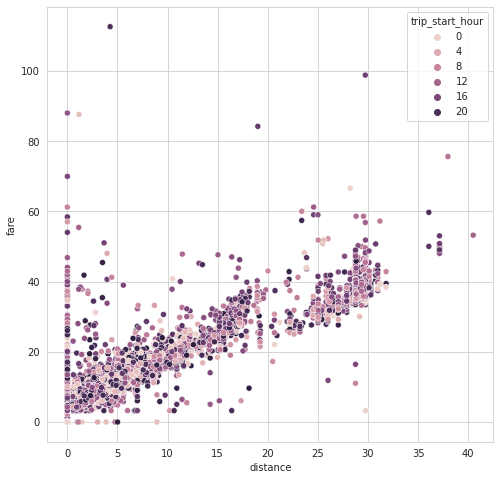

In [61]:
## fare vs distance
plt.figure(figsize=(8, 8))
sns.scatterplot(x=traindf['distance'], y=traindf['fare'], hue=traindf['trip_start_hour'].astype(int))

In [62]:
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)
traindf.head()

12347
2171


,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
28,12.25,10,1,1,41.952823,-87.653244,41.920452,-87.679955
29,3.85,3,15,6,41.899670,-87.669838,41.920452,-87.679955
30,6.05,8,23,5,41.906026,-87.675312,41.920452,-87.679955
31,7.25,10,21,7,41.906651,-87.665338,41.920452,-87.679955
32,7.85,11,11,2,41.871016,-87.631407,41.849247,-87.624135


#Data Ingestion Pipeline

In [ ]:
evaldf.info()

In [ ]:
traindf.info()

In [ ]:
##Feature engineering functions
def feature_engg_features(features):
  #Add new features
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)  

In [ ]:
CSV_COLUMNS = traindf.columns
LABEL_COLUMN = 'fare'

# Set default values for each CSV column
DEFAULTS = [[0.0], ['1'], ['1'],['1'],[0.0],[0.0],[0.0],[0.0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs 
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        return dataset
    return _input_fn

In [ ]:
CSV_COLUMNS

In [ ]:
# Testing make_input_fn
eval_file = "train*.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

In [ ]:
traindf.info()

In [ ]:
# Define feature columns
def create_feature_cols():
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

##Training pipeline

In [ ]:
#Create model
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}


def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing

    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)
    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

In [ ]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  steps_per_epoch = 100, 
                  callbacks=[reduce_lr, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True), tensorboard_callback]
                  )

In [ ]:
#Create dataset input functions
train_dataset = make_input_fn(filename = 'train*.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    batch_size = 128)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    batch_size = 512)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [ ]:
!rm -rf "./logs"
%tensorboard --logdir "./logs"

keras_train_and_evaluate(m_, train_dataset, validation_dataset, 50)

##Serving: Export Model

In [ ]:
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[41.920452]],
                         'dropoff_longitude': [[-87.679955]],
                         'pickup_latitude': [[41.952823]],
                         'pickup_longitude': [[-87.653244]],
                         'trip_start_day': [["1"]],
                         'trip_start_hour': [["5"]],
                         'trip_start_month': [["6"]],
                         'distance':[[0.04196861]]})

m_.predict(data)

In [ ]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, trip_start_day, trip_start_hour, trip_start_month):
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'trip_start_day': trip_start_day,
        'trip_start_hour': trip_start_hour,
        'trip_start_month': trip_start_month,
        'distance': distance
    }
    
    ## Predict
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(trip_start_day=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_day'), 
                                        trip_start_hour=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_hour'),
                                        trip_start_month=tf.TensorSpec([None], dtype= tf.string, name='trip_start_month'), 
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 


In [ ]:
# !zip -r /content/model.zip /content/exported_model/1
!tar -cvf /content/model.tar /content/exported_model/1/

In [ ]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all

In [ ]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("./exported_model/" + version)

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor(["1"]), trip_start_hour=tf.convert_to_tensor(["5"]),
  trip_start_month=tf.convert_to_tensor(["6"]))

In [ ]:
## Install TF Model server

!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

In [ ]:
###Start Tensorflow server
# %%bash --bg 
# export TF_CPP_MIN_VLOG_LEVEL=0

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

In [ ]:
!tail server.log

##Inference

In [ ]:
import json
import requests

#Create payload
data_py = {"instances":[{'dropoff_latitude': 41.920452,
                         'dropoff_longitude': -87.679955,
                         'pickup_latitude': 41.952823,
                         'pickup_longitude': -87.653244,
                         'trip_start_day': "1",
                         'trip_start_hour': "5",
                         'trip_start_month': "6"}]}

data = json.dumps(data_py)
print("payload: ", data)

#Run request on TMS
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8505/v1/models/model:predict', data=data, headers=headers)

In [ ]:
!ls -lh